# Align flu pacbio reads

This notebook imports, aligns and filters pacbio amplicons. 

In [1]:
import os
import re
import warnings

from IPython.display import HTML, display

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

import pandas as pd

import plotnine as p9

In [2]:
warnings.simplefilter('ignore')

In [3]:
p9.theme_set(dms_variants.plotnine_themes.theme_graygrid())

Import snakemake variables

amplicons = snakemake.input.amplicons
features = snakemake.input.features
plot_amplicons = snakemake.output.plot_amplicons
plot_alignment = snakemake.output.plot_alignment
ccs_report = snakemake.input.ccs_report
ccs_fastq = snakemake.input.ccs_fastq
runs = snakemake.params.runs
amplicon_to_reference_df = snakemake.input.amplicon_to_reference_df
alignment_stats = snakemake.params.alignment_stats
mutation_df = snakemake.output.mutation_df
threads = snakemake.threads

In [4]:
amplicons = "../data/flu_sequences/pacbio_amplicons/fluCA09.gb"
features = "../data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml"
plot_amplicons = "../results/pacbio/hashing_highMOI_amplicons.svg"
plot_alignment = '../results/_temp2.svg'
ccs_report = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt"
ccs_fastq = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs_fixterm.fastq.gz"
runs = ["hashing_highMOI_2020-10-20_all_segments_run1"]
alignment_stats= "../results/pacbio/CA09_align_and_parse"
amplicon_to_reference_df = "../data/flu_sequences/pacbio_amplicons/amplicon_to_reference.csv"
mutation_df = '../results/_temp.csv'
os.makedirs(alignment_stats, exist_ok=True)
threads=8

## Import target amplicons
Here we import target files for amplicons that where made using primers that either aligned to ends of flu sequences ('termini') or primers aligning approximately to the middle of a segment ('mid').

In [5]:
targetfile = amplicons

nlines_to_show = 100
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

LOCUS       HAmid                2123 bp ds-DNA     linear   SYN 05-NOV-2020
DEFINITION  HAmid
ACCESSION   HAmid
VERSION     .
KEYWORDS    .
SOURCE      HAmid
  ORGANISM  PCR product
FEATURES             Location/Qualifiers
     sequenced_ORF_1 1..870
     variant_tag_2    750
     viral_barcode    892..907
     polyA            1079..1107
     UMI              1108..1119
     cellbarcode      1120..1135
     Read1            1136..1155
     termini5         1156..1260
     termini3         871..1078
     sequenced_ORF_2  1261..2123
     variant_tag_1    1404
ORIGIN
        1 gctggatctg gtattatcat ttcagataca ccagtccacg attgcaatac aacttgtcaa
       61 acacccaagg gtgctataaa caccagcctc ccatttcaga atatacatcc gatcacaatt
      121 ggaaaatgtc caaaatatgt aaaaagcaca aaattgagac tggccacagg attgaggaat
      181 atcccgtcta ttcaatctag aggcctattt ggggccattg ccggtttcat tgaagggggg
      241 tggacaggga tggtagatgg atggtacggt tatcaccatc aaaatgagca ggggtcagga
      301 tatgcagccg acctgaagag cacacagaat gcca

Feature file defines features in amplicon genbank file.

In [6]:
feature_parse_specs_file = features
with open(feature_parse_specs_file) as f:
    print(f.read())

# default for genes with two variant tags
default_2tags: &default_2tags
  query_clip5: 5
  query_clip3: 5
  termini5:
    filter:
      mutation_nt_count: 2
      mutation_op_count: null
    return: [mutations, accuracy]
  termini3:
    filter:
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  sequenced_ORF_1:
    filter:
      clip5: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  sequenced_ORF_2:
    filter:
      clip3: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  polyA:
    filter:
      mutation_nt_count: null
      mutation_op_count: 4
  UMI:
    return: [sequence, accuracy]
  cellbarcode:
    return: [sequence, accuracy]
  variant_tag_1:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
  variant_tag_2:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
# defau

In [7]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags',
                                                 'default_1tag'],
                allow_extra_features=True,
                allow_clipped_muts_seqs=True)

Now let's plot all segment amplicons and save plots as a figure. 

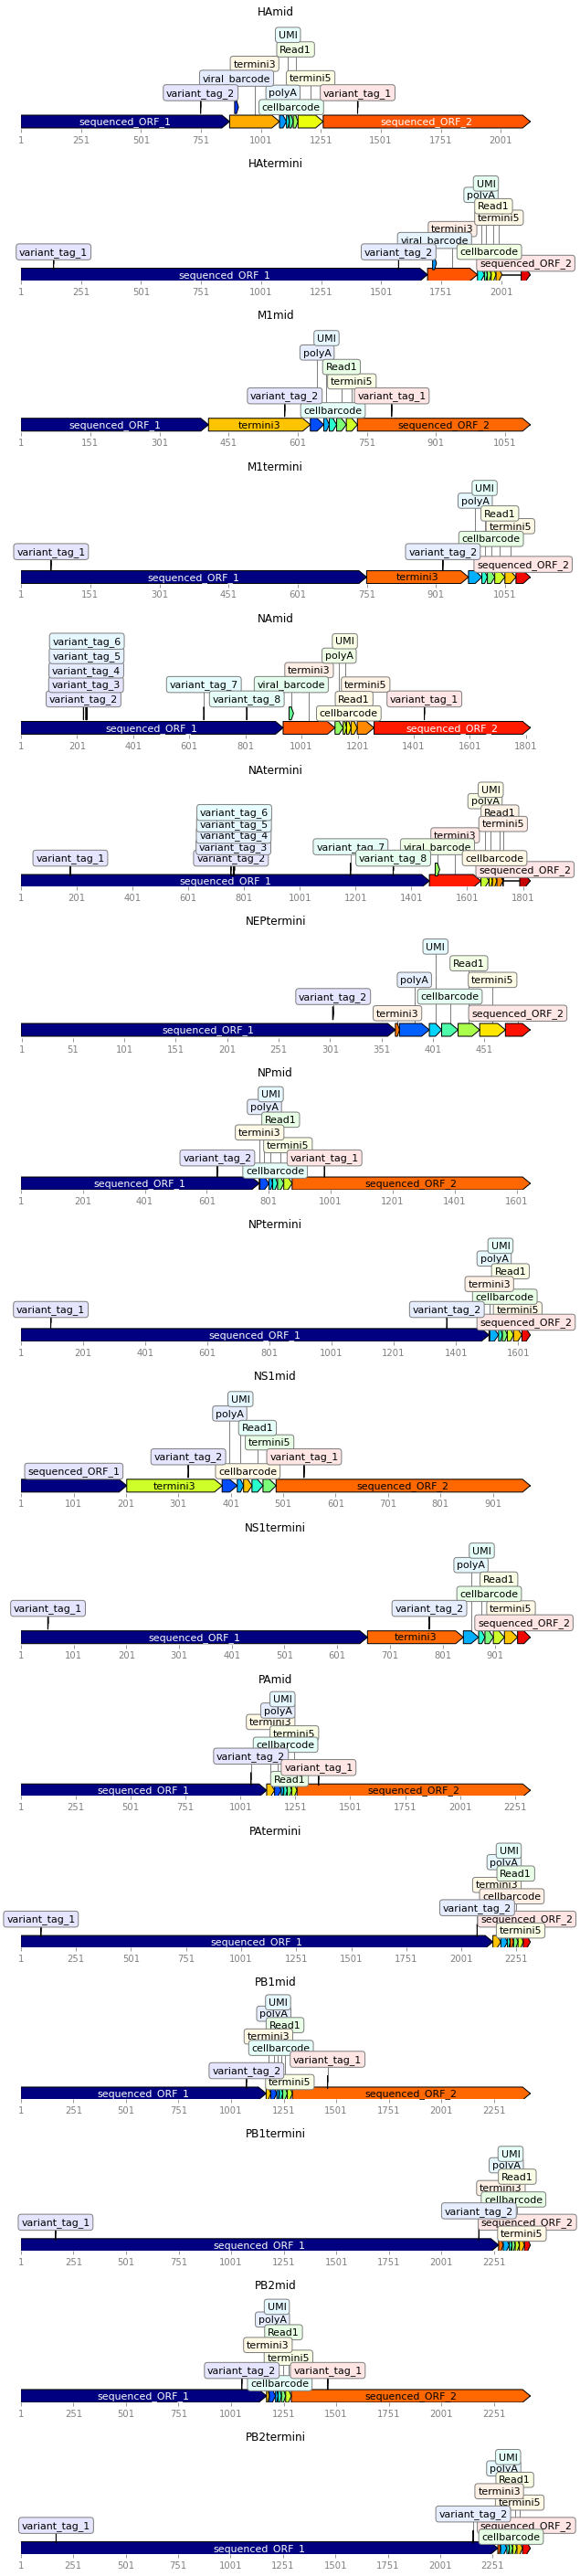

In [8]:
plot = targets.plot(ax_width=10)

In [9]:
print(f"Saving figure to {plot_amplicons}")
plot.savefig(plot_amplicons, format="svg")

Saving figure to ../results/pacbio/hashing_highMOI_amplicons.svg


## Align pacbio reads

Create packbio run dataframe

In [10]:
pacbio_runs = pd.DataFrame(
    {'name': runs, 'fastq': ccs_fastq, 'report': ccs_report}
)
display(HTML(pacbio_runs.to_html(index=False)))

name,fastq,report
hashing_highMOI_2020-10-20_all_segments_run1_ccs,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs_fixterm.fastq.gz,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt


Now align all ccs to amplicons and filter for the ones that meet criteria defined in `fluCA09_features.yaml`.

Create an alignparse.minimap2.Mapper to run minimap2 with minimap [options](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_VIRUS_W_DEL) that allow for large deletions in viral sequences. 

In [11]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS_W_DEL)

print(f"Using `minimap2` {mapper.version} with these options:\n"
      + ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-xsplice:hq -un -C0 --splice-flank=no -M=1 --end-seed-pen=2 --end-bonus=2 --secondary=no --cs


In [12]:
align_and_parse_outdir = os.path.join(alignment_stats)

In [13]:
readstats, aligned, filtered = targets.align_and_parse(
    df=pacbio_runs,
    mapper=mapper,
    outdir=align_and_parse_outdir,
    name_col='name',
    queryfile_col='fastq',
    overwrite=True,  # overwrite any existing output
    to_csv=True,
    ncpus=threads,
)

Here are read alignment statistics telling how many reads have been aligned or filtered out for each reference amplicon.

In [14]:
readstats.head()

,name,category,count
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered HAmid,3686
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned HAmid,11322
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered HAtermini,2171
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned HAtermini,4054
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered M1mid,405


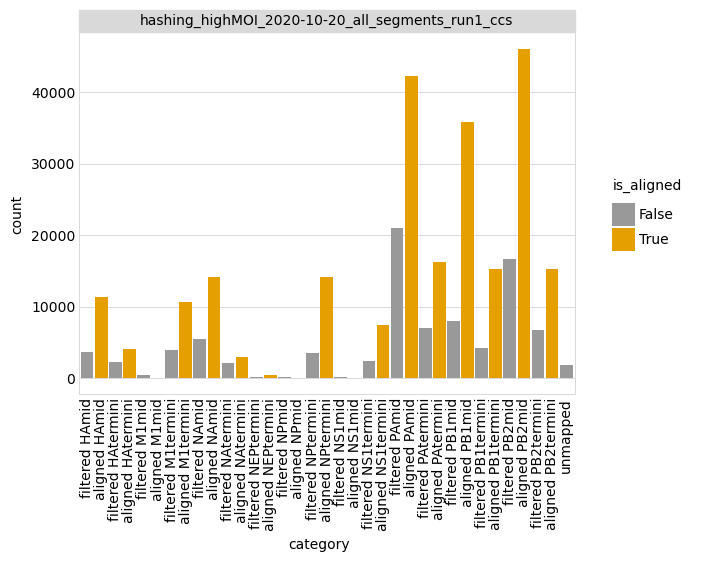

In [15]:
p = (
    p9.ggplot(readstats.assign(
        category=lambda x: pd.Categorical(x['category'],
                                          x['category'].unique(),
                                          ordered=True),
        is_aligned=lambda x: x['category'].str.contains('aligned'),),
        p9.aes('category', 'count', fill='is_aligned'))
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('~ name', nrow=1)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.scale_fill_manual(values=CBPALETTE)
)
_ = p.draw()

p9.ggsave(plot=p, filename=plot_alignment, verbose=False)

Now lets look at the most common reasons why some reads have been filtered out.

In [16]:
concatenated_ff_df = pd.DataFrame()
for filtered_file in filtered:
    ff = pd.read_csv(filtered[filtered_file], na_filter=False)
    ff['gene'] = filtered_file
    concatenated_ff_df = pd.concat([concatenated_ff_df, ff], axis=0)
concatenated_ff_df.head()

,name,query_name,filter_reason,gene
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194761/ccs,query_clip5,HAmid
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194985/ccs,query_clip5,HAmid
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4260097/ccs,termini5 clip3,HAmid
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4260187/ccs,sequenced_ORF_2 clip3,HAmid
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4325657/ccs,query_clip5,HAmid


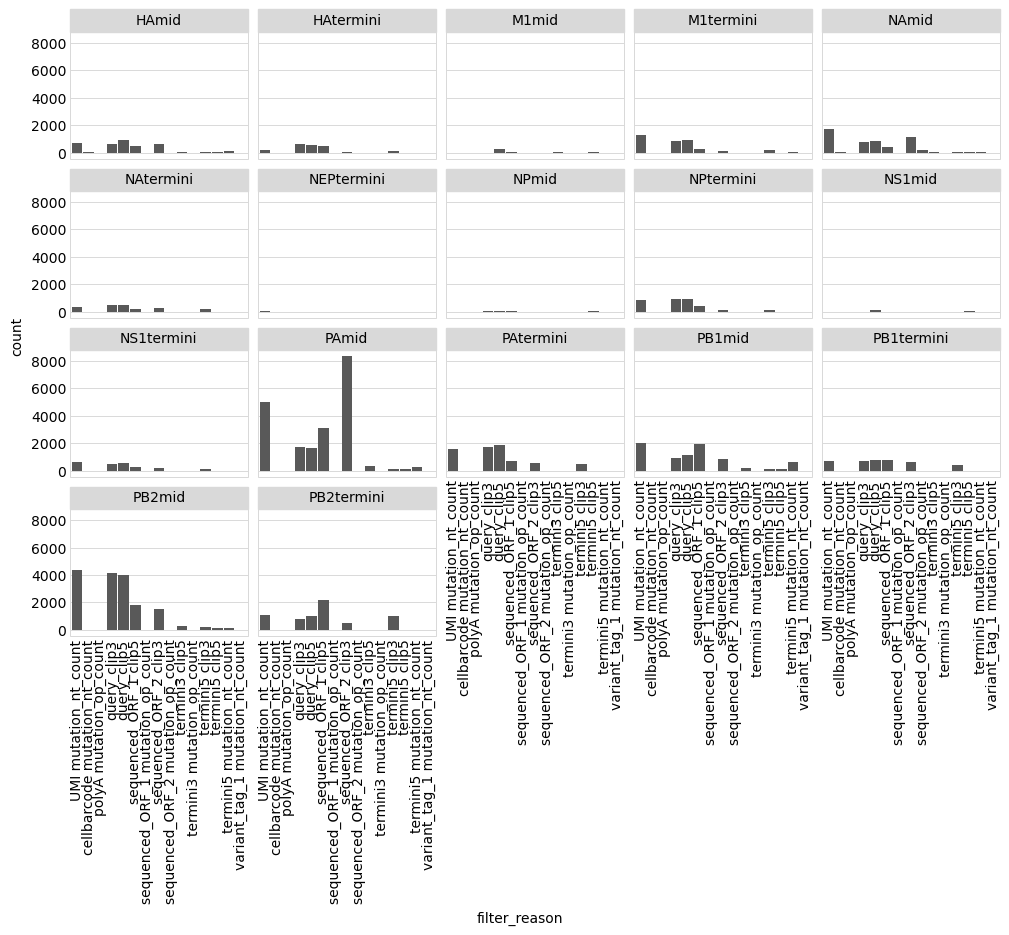

In [17]:
p = (
    p9.ggplot(concatenated_ff_df, p9.aes('filter_reason'))
    + p9.geom_bar()
    + p9.facet_wrap('~ gene', ncol=5)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               figure_size=(12, 8),
               panel_grid_major_x=p9.element_blank(),
               )
    )
_ = p.draw()

## Convert amplicon sequence positions to wt

Here we import file that contains a lookup table. We will make a dictionary out of it to tell what position in reference sequence is equivalent to position in an amplicon sequence.

In [23]:
amplicon_to_reference = pd.read_csv(amplicon_to_reference_df)
amplicon_to_reference.head()

,target,gene,wt_nt,ORF_position,sequenced_ORF_1,sequenced_ORF_2,termini5,termini3
0,PB2termini,fluPB2,A,-27,NaN,NaN,1.0,NaN
1,PB2termini,fluPB2,G,-26,NaN,NaN,2.0,NaN
2,PB2termini,fluPB2,C,-25,NaN,NaN,3.0,NaN
3,PB2termini,fluPB2,G,-24,NaN,NaN,4.0,NaN
4,PB2termini,fluPB2,A,-23,NaN,NaN,5.0,NaN


We extract feature names from `amplicon_to_reference` file. The first four columns are `target`, `gene`, `wt_nt`, and `ORF_position` and are not relevant to features, so we will not include them. 

In [24]:
column_names = amplicon_to_reference.columns.tolist()
assert amplicon_to_reference.columns.tolist()[:4] == ['target', 'gene', 'wt_nt', 'ORF_position'], amplicon_to_reference
amplicon_features = column_names[4:]
print(amplicon_features)

['sequenced_ORF_1', 'sequenced_ORF_2', 'termini5', 'termini3']


Here are the aligned files made by `targets.align_and_parse`.

In [25]:
for aligned_files in aligned:
    print(aligned[aligned_files])

../results/pacbio/CA09_align_and_parse/HAmid_aligned.csv
../results/pacbio/CA09_align_and_parse/HAtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/M1mid_aligned.csv
../results/pacbio/CA09_align_and_parse/M1termini_aligned.csv
../results/pacbio/CA09_align_and_parse/NAmid_aligned.csv
../results/pacbio/CA09_align_and_parse/NAtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/NEPtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/NPmid_aligned.csv
../results/pacbio/CA09_align_and_parse/NPtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/NS1mid_aligned.csv
../results/pacbio/CA09_align_and_parse/NS1termini_aligned.csv
../results/pacbio/CA09_align_and_parse/PAmid_aligned.csv
../results/pacbio/CA09_align_and_parse/PAtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/PB1mid_aligned.csv
../results/pacbio/CA09_align_and_parse/PB1termini_aligned.csv
../results/pacbio/CA09_align_and_parse/PB2mid_aligned.csv
../results/pacbio/CA09_align_and_parse/PB2termini_

Here we read in each aligned segment csv file that was made by `targets.align_and_parse`. Then for each amplicon feature we make a dictionary from `amplicon_to_reference` file and use regex to change each nucleotide position in an amplicon to equivalent position in the reference sequence. 

In [26]:
# Define a class to renumber mutations

class MutationRenumber:
    """Re-number mutations.
    
    Arguments
    ----------
    number_mapping : pandas.DataFrame
        Data frame giving mapping from old to new numbering scheme.
    old_num_col : str
        Column in `number_mapping` giving old site number.
    new_num_col : str
        Column in `number_mapping` giving new site number.
    wt_nt_col : str or None
        Column in `number_mapping` giving wildtype nucleotide at each site,
        or `None` to not check identity.
    err_suffix : str
        Append this message to any errors raised about invalid sites or
        mutation strings. Can be useful for debugging.
        
    Attributes
    ----------
    old_to_new_site : dict
        Maps old site number to new one.
    old_to_wt : dict or None
        Maps old site number to wildtype nucleotide if using `wt_nt_col`.
        
    Example
    --------
    >>> number_mapping = pd.DataFrame({'old': [1, 2, 3],
    ...                                'new': [5, 6, 7],
    ...                                'wt_nt': ['A', 'C', 'G']})
    >>> renumberer = MutationRenumber(number_mapping=number_mapping,
    ...                               old_num_col='old',
    ...                               new_num_col='new',
    ...                               wt_nt_col='wt_nt')
    >>> renumberer.old_to_new_site
    {1: 5, 2: 6, 3: 7}
    >>> renumberer.old_to_wt
    {1: 5, 2: 6, 3: 7}
    >>> renumberer.renumber_muts('A1C del2to3 ins3GC')
    'A5C del6to7 ins7GC'
    
    """
    
    def __init__(self, number_mapping, old_num_col, new_num_col, wt_nt_col,
                 *, err_suffix=''):
        """See main class docstring."""
        self._err_suffix = err_suffix
        for col in [old_num_col, new_num_col]:
            if col not in number_mapping.columns:
                raise ValueError(f"`number_mapping` lacks column {col}" +
                                 self._err_suffix)
            if number_mapping[col].dtype != int:
                raise ValueError(f"`number_mapping` column {col} not integer" +
                                 self._err_suffix)
        self.old_to_new_site = (number_mapping
                                .set_index(old_num_col)
                                [new_num_col]
                                .to_dict()
                                )
        if not (len(self.old_to_new_site) == 
                len(set(self.old_to_new_site.values())) ==
                len(number_mapping)):
            raise ValueError('site numbers not unique' + self._err_suffix)
            
        self._old_to_new_site_str = {str(old): str(new) for old, new
                                     in self.old_to_new_site.items()}
                
        if wt_nt_col:
            if wt_nt_col not in number_mapping.columns:
                raise ValueError(f"`number_mapping` lacks column {col}" +
                                 self._err_suffix)
            if not all(isinstance(nt, str) and len(nt) == 1
                       for nt in number_mapping[wt_nt_col]):
                raise ValueError(f"`number_mapping` column {col} not all letters" +
                                 self._err_suffix)
            self.old_to_wt = (number_mapping
                              .set_index(old_num_col)
                              [wt_nt_col]
                              .to_dict()
                              )
            self._old_to_wt_str = {str(old): wt for old, wt
                                   in self.old_to_wt.items()}
        else:
            self.old_to_wt = None
            
    def renumber_muts(self, mut_str):
        """Get re-numbered mutation string.
        
        Parameters
        ----------
        mut_str : str
            Mutations in format 'A1C del2to3 ins3GG'.
            
        Returns
        -------
        str
            A version of `mut_str` where sites have been renumbered.
        
        """
        new_muts = []
        for mut in mut_str.split():
            try:
                # try to match substitutions
                m = re.fullmatch('(?P<wt>[A-Z])(?P<site>\d+)(?P<mut>[A-Z])', mut)
                if m:
                    new_muts.append(
                            m.group('wt') +
                            self._old_to_new_site_str[m.group('site')] +
                            m.group('mut')
                            )
                    continue
                # try to match insertion
                m = re.fullmatch('ins(?P<site>\d+)(?P<insertion>[A-Z]+)', mut)
                if m:
                    new_muts.append(
                            'ins' +
                            self._old_to_new_site_str[m.group('site')] +
                            m.group('insertion')
                            )
                    continue
                # try to match deletion
                m = re.fullmatch('del(?P<site1>\d+)to(?P<site2>\d+)', mut)
                if m:
                    new_muts.append(
                            'del' +
                            self._old_to_new_site_str[m.group('site1')] +
                            'to' +
                            self._old_to_new_site_str[m.group('site2')]
                            )
                    continue
                # problem if we made it here, couldn't match anything
                raise ValueError(f"Cannot match {mut} in {mut_str}" +
                                 self._err_suffix)
            except KeyError:
                raise ValueError(f"Mutation {mut} has site out of numbering range"
                                 + self._err_suffix)
        return ' '.join(new_muts)

In [36]:
orf_numbered_alignments = pd.DataFrame()

for target, alignments_csv in aligned.items():

    alignments = pd.read_csv(alignments_csv, na_filter=False)
    
    print(f"Analyzing {len(alignments)} aligned CCSs for {target}")
    
    for feature in amplicon_features:
        number_mapping = (
                amplicon_to_reference
                .query('target == @target')
                .query(f"{feature}.notnull()", engine='python')
                .assign(feature_num=lambda x: x[feature].astype(int))
                )
        
        renumberer = MutationRenumber(number_mapping=number_mapping,
                                      old_num_col='feature_num',
                                      new_num_col='ORF_position',
                                      wt_nt_col=None,
                                      err_suffix=f" for {feature} in {target}",
                                      )
                            
        alignments[f"{feature}_mutations_orf_numbered"] = (
                    alignments[f"{feature}_mutations"]
                    .map(renumberer.renumber_muts)
                    )
    
    alignments['target'] = target
    orf_numbered_alignments = orf_numbered_alignments.append(alignments)

print(f"\nWriting ORF-numbered alignments to {mutation_df}")
orf_numbered_alignments.to_csv(mutation_df, index=False)

Analyzing 11322 aligned CCSs for HAmid
Analyzing 4054 aligned CCSs for HAtermini
Analyzing 0 aligned CCSs for M1mid
Analyzing 10648 aligned CCSs for M1termini
Analyzing 14119 aligned CCSs for NAmid
Analyzing 3007 aligned CCSs for NAtermini
Analyzing 355 aligned CCSs for NEPtermini
Analyzing 0 aligned CCSs for NPmid
Analyzing 14120 aligned CCSs for NPtermini
Analyzing 0 aligned CCSs for NS1mid
Analyzing 7423 aligned CCSs for NS1termini
Analyzing 42304 aligned CCSs for PAmid
Analyzing 16217 aligned CCSs for PAtermini
Analyzing 35855 aligned CCSs for PB1mid
Analyzing 15321 aligned CCSs for PB1termini
Analyzing 46125 aligned CCSs for PB2mid
Analyzing 15214 aligned CCSs for PB2termini
Writing ORF-numbered alignments to ../results/_temp.csv


In [33]:
alignments

,name,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,...,UMI_accuracy,cellbarcode_sequence,cellbarcode_accuracy,variant_tag_1_sequence,variant_tag_2_sequence,sequenced_ORF_1_mutations_orf_numbered,target,sequenced_ORF_2_mutations_orf_numbered,termini5_mutations_orf_numbered,termini3_mutations_orf_numbered
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194422/ccs,0,1,del25to25,1.0,,0.9999999994988129,,1.000000,...,0.972814,CTACCAGGATTACGGT,0.985971,A,G,,PB2termini,,del-3to-3,
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194459/ccs,0,0,,1.0,ins13CAAA T13A,0.9999999994988128,del242to2090,1.000000,...,0.989509,GGTCCAGTGATAGTAG,1.000000,A,G,del247to2095,PB2termini,,,ins2293CAAA T2293A
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194555/ccs,0,0,,1.0,T12C,0.9999999994988129,,0.999999,...,0.998337,CCTATGATGATCCTCA,0.999503,G,A,,PB2termini,,,T2292C
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194591/ccs,1,0,,1.0,T13C,0.9999999994988129,,0.999999,...,1.000000,TACATGCAACTTCGGC,0.999999,A,G,,PB2termini,,,T2293C
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194730/ccs,1,0,,1.0,ins13AAAAA,0.9993005744145973,del90to2108 C2110G C2111A T2118C ins2156A,0.999610,...,0.999983,CTCTAACGCCTCAGTG,1.000000,,G,del95to2113 C2115G C2116A T2123C ins2161A,PB2termini,,,ins2293AAAAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/74908468/ccs,0,0,,1.0,del1to13,nan,del557to559 G562A del566to2275,0.999998,...,1.000000,AAGCGGAACAATCCCA,1.000000,A,,del562to564 G567A del571to2280,PB2termini,,,del2281to2293
15210,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/74908522/ccs,0,0,,1.0,ins13C T13A,0.999999999498813,del183to2160,0.999996,...,0.973648,TATGATCCTACCCGTG,1.000000,G,,del188to2165,PB2termini,,,ins2293C T2293A
15211,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/74908601/ccs,0,0,,1.0,T12C T13C,0.9999999994988129,del183to2160,1.000000,...,0.999997,TTACCTGATCGTTGTG,0.997314,G,,del188to2165,PB2termini,,,T2292C T2293C
15212,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/74908638/ccs,0,0,,1.0,del1to13,nan,del553to2275,1.000000,...,1.000000,CTGTGTCTGACCAGAG,1.000000,A,,del558to2280,PB2termini,,,del2281to2293


In [28]:
concatenated_amplicons = pd.DataFrame()

for alignment in aligned:
    af = pd.read_csv(aligned[alignment], na_filter=False)
    print('Analyzing alignments to ' + alignment + ' target using '
          + aligned[alignment] + ' dataframe')
    
    if af.empty:
        print('no aligned CCSs found for ' + alignment)

    else:
        reference = amplicon_to_reference.loc[
            (amplicon_to_reference['target'] == alignment),
            ["target", "ORF_position", *amplicon_features]
        ]

        for ap_feature in amplicon_features:
            # first we build a dictionary
            # to find positions in reference sequence
            ref_dict = {}
            ref_site_mutation_list = []

            for _feature, df in reference.groupby(ap_feature):
                assert (df['target'] == alignment).all()
                df['ORF_position'] = df['ORF_position'].astype(str)
                feature_num_to_orf_num_dict = (df
                                               .query(f'{ap_feature} == @_feature')
                                               .set_index(ap_feature)['ORF_position']
                                               .to_dict()
                                               )
                ref_dict.update(feature_num_to_orf_num_dict)

            if any(ref_dict) is False:
                print("no " + ap_feature + " in " + alignment)
                continue
            # the first element in the dictionary is always
            # an empty key that should be deleted
            del ref_dict['']

            # here we use regex to change amplicon
            # positions to positions in refrence
            for _index, row in af.iterrows():
                feature_col = row[ap_feature + '_mutations']
                dictionary = ref_dict
                pattern = re.compile(r'(?<!\d)(' + '|'
                                     .join(re.escape(key) for key in dictionary
                                           .keys()) + r')(?!\d)')
                result = pattern.sub(lambda x: dictionary[x.group()], feature_col)
                ref_site_mutation_list.append(result)

            ref_site_mutation_df = pd.DataFrame(ref_site_mutation_list)
            # attach reference-numbered mutations
            af[ap_feature + '_reference'] = ref_site_mutation_df
        af['target'] = alignment
        concatenated_amplicons = pd.concat([concatenated_amplicons, af], axis=0)
concatenated_amplicons.to_csv(mutation_df, index=False)


Analyzing alignments to HAmid target using ../results/pacbio/CA09_align_and_parse/HAmid_aligned.csv dataframe


KeyError: ''

In [48]:
new = pd.read_csv('../results/_temp.csv')
old = pd.read_csv('../results/_temp2.csv')

In [ ]:
for new_row, old_row in zip(new.iterrows(), old.iterrows()):
    new_vals = str(new_row[1].values)
    old_vals = str(old_row[1].values)
    if new_vals != old_vals:
        print(f"{new_vals}\n{old_vals}\n")

In [ ]:
aligned

In [ ]:
alignments